In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt
import random
import datetime

plt.rcParams['font.sans-serif'] = ['AR PL UKai CN']             # display chinese label
plt.rcParams['font.family'] = 'AR PL UKai CN' 

chars = ["京", "沪", "津", "渝", "冀", "晋", "蒙", "辽", 
         "吉", "黑", "苏", "浙", "皖", "闽", "赣", "鲁",
         "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵",
         "云", "藏", "陕", "甘", "青", "宁", "新", "0", 
         "1", "2", "3", "4", "5", "6", "7", "8", "9",
         "A", "B", "C", "D", "E", "F", "G", "H", "J",
         "K", "L", "M", "N", "P", "Q", "R", "S", "T",
         "U", "V", "W", "X", "Y", "Z"]                          # all chars

SIZE = len(chars)                                               # total number of all chars  
LEN = 7                                                         # total number of chars in plate
IMAGE_HEIGHT = 50                                               # image height
IMAGE_LENGTH = 36                                               # image length of one char
IMAGE_TOTLENGTH = IMAGE_LENGTH*LEN                              # image length in total

TEXT_COLOR = (225, 225, 225)                                    # white char
BG_COLOR = (0, 0, 225)                                          # blue plate
TEXT_SIZE = 44                                                  # char size
CHFONT = ImageFont.truetype("./ch.ttf", int(TEXT_SIZE*0.8))     # chinese font
EDFONT = ImageFont.truetype("./ed.ttf", TEXT_SIZE)              # english-digit font

M = 5000                                                        # total number of instances

In [2]:
def rdm(i):
    if i == 0:
        return random.randint(0, 30)                            # first: chinese
    elif i == 1:
        return random.randint(41, 64)                           # second: en-letter
    else:
        return random.randint(31, 64)                           # rest: en or di

def rx():
    return random.randint(0, IMAGE_HEIGHT)

def ry():
    return random.randint(0, IMAGE_LENGTH)

def rrgb():
    return random.randint(50, 205)

In [3]:
def generate_plate():
    text = ""                                                   # generate string of plate
    hotvec = np.zeros((LEN*SIZE))                               # generate one-hot vector
    for i in range(LEN):
        d = rdm(i)                                              # random char
        hotvec[i*SIZE+d] = 1
        text = text + chars[d]
    return text, hotvec

def to_text(hotvec):                                            # convert ont-hot to string
    text = ''
    hotvec = np.asarray(hotvec).reshape(LEN, SIZE)
    for item in hotvec:
        text += chars[np.argmax(item)]                          # choose the largest in one-hot
    return text

In [4]:
def generate_char(val, ft):                                     # draw char with random line
    img = Image.new("RGB", (IMAGE_LENGTH,IMAGE_HEIGHT), BG_COLOR)
    draw = ImageDraw.Draw(img)
    draw.text((0,0), val, TEXT_COLOR, ft)
    draw.line([(rx(),ry()),(rx(),ry()),(rx(),ry())], fill = (rrgb(),rrgb(),rrgb()), width = 8)
    return np.array(img)

In [5]:
def generate_image(text):
    image = np.array(Image.new("RGB", (IMAGE_TOTLENGTH,IMAGE_HEIGHT), BG_COLOR))
    image[:, :IMAGE_LENGTH] = generate_char(text[0], CHFONT)
    image[:, IMAGE_LENGTH:IMAGE_LENGTH*2] = generate_char(text[1], EDFONT)
    for i in range(2, LEN):
        image[:, IMAGE_LENGTH*i:IMAGE_LENGTH*(i+1)] = generate_char(text[i], EDFONT)
    noise_b = 150                                               # add noise
    noise = np.random.randint(-noise_b, noise_b, size=(IMAGE_HEIGHT,IMAGE_TOTLENGTH,3))
    return (image+noise+noise_b)*255//(255+2*noise_b)

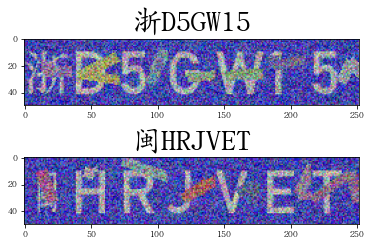

In [6]:
for i in range(2):
    te, vec = generate_plate()
    timg = generate_image(te)
    plt.subplot(2, 1, i+1)
    plt.imshow(timg)
    plt.title(te, fontsize=30)

In [7]:
def get_data(m):                                                 # generate m instances
    X = np.zeros((m, IMAGE_HEIGHT, IMAGE_TOTLENGTH, 3))
    Y = np.zeros((m, LEN*SIZE))
    for i in range(m):
        text, hotvec = generate_plate()
        image = generate_image(text)
        image = image / 255                                      # normalization
        X[i] = image.copy()
        Y[i] = hotvec.copy()
    return X, Y.astype(np.uint8)

In [8]:
X_train, Y_train = get_data(int(M*0.8))
X_test, Y_test = get_data(int(M*0.2))

In [9]:
X_train.shape[:], Y_train.shape[:]

((4000, 50, 252, 3), (4000, 455))

In [10]:
input_tensor = keras.layers.Input((IMAGE_HEIGHT, IMAGE_TOTLENGTH, 3))
x = input_tensor

for i in range(4):
    x = keras.layers.Conv2D(32 * 2**i, (3,3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D((2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.25)(x)

x = [keras.layers.Dense(SIZE, activation='softmax', name='c%d'%(i+1))(x) for i in range(LEN)]
x = keras.layers.Concatenate()(x)

model = keras.Model(inputs=input_tensor, outputs=x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 252, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 252, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 25, 126, 32)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 126, 64)  18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

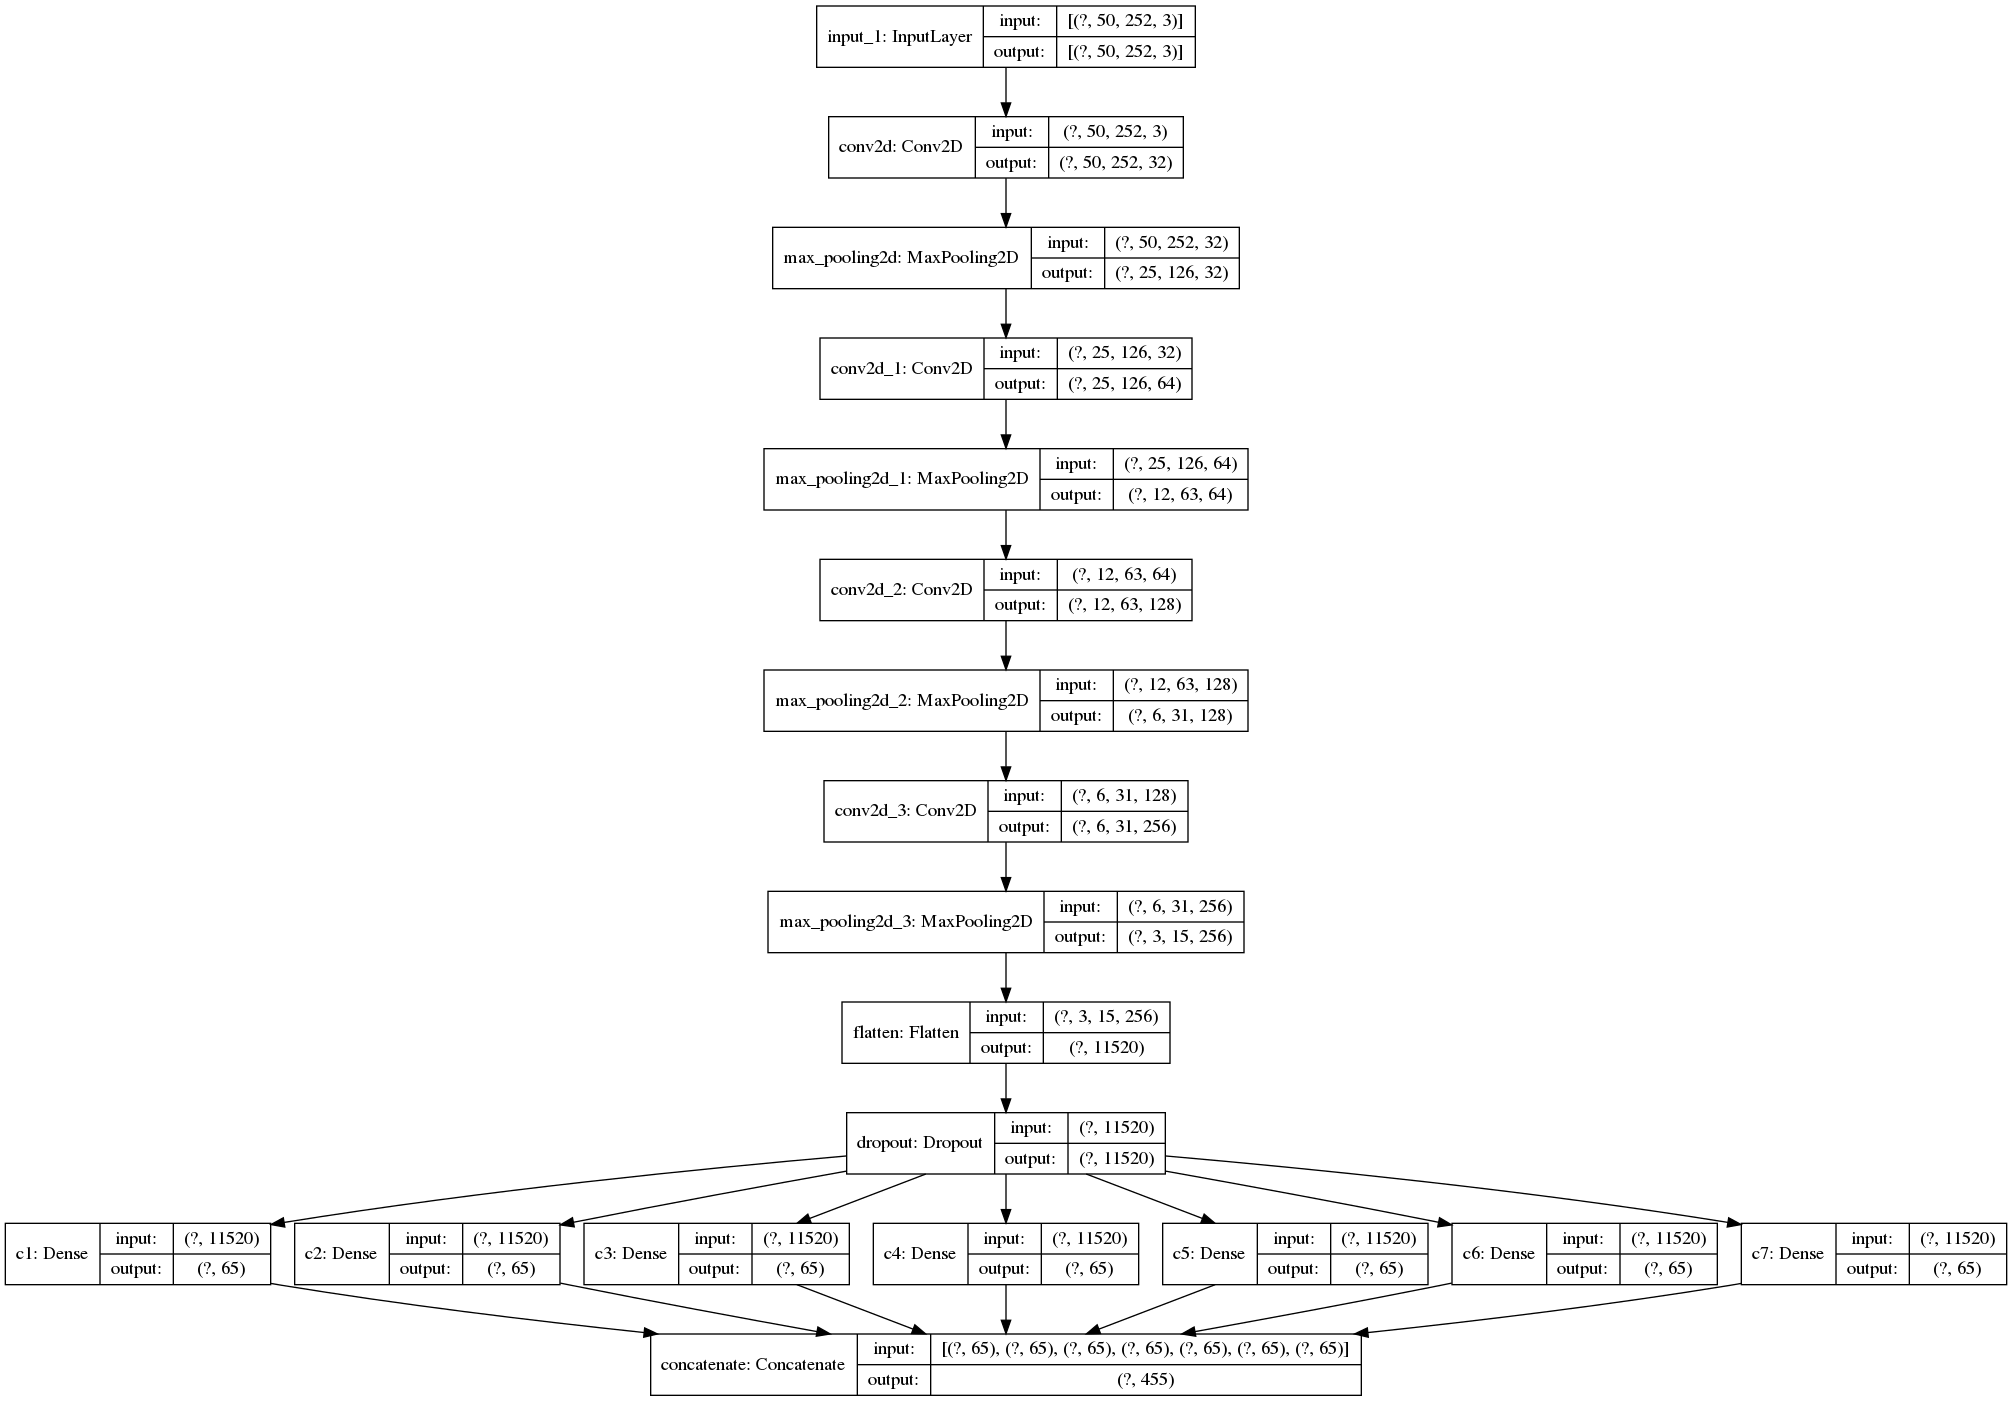

In [11]:
keras.utils.plot_model(model, to_file='./model.png', show_shapes=True)

In [12]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [13]:
!rm -rf ./logs/ 

log_dir = "./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = [keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)]

In [14]:
history = model.fit(
    X_train,
    Y_train,
    epochs=10,
    callbacks=tensorboard_callback,
)

Epoch 1/10
125/125 [==============================] - 61s 486ms/step - loss: 0.0696 - accuracy: 0.0018
Epoch 2/10
125/125 [==============================] - 59s 473ms/step - loss: 0.0683 - accuracy: 0.0010
Epoch 3/10
125/125 [==============================] - 59s 473ms/step - loss: 0.0356 - accuracy: 0.0205
Epoch 4/10
125/125 [==============================] - 59s 474ms/step - loss: 0.0071 - accuracy: 0.0487
Epoch 5/10
125/125 [==============================] - 59s 474ms/step - loss: 0.0022 - accuracy: 0.0562
Epoch 6/10
125/125 [==============================] - 59s 472ms/step - loss: 0.0011 - accuracy: 0.0683
Epoch 7/10
125/125 [==============================] - 59s 473ms/step - loss: 7.2556e-04 - accuracy: 0.0793
Epoch 8/10
125/125 [==============================] - 59s 473ms/step - loss: 4.9834e-04 - accuracy: 0.0868
Epoch 9/10
125/125 [==============================] - 59s 474ms/step - loss: 3.9364e-04 - accuracy: 0.0940
Epoch 10/10
125/125 [==============================] - 59s 47

In [15]:
Y_predict = model.predict(X_test)
sum = 0
for i in range(len(X_test)):
    sum += to_text(Y_predict[i]) == to_text(Y_test[i])
print(sum, '/', len(X_test))
print("Accuracy:", sum / len(X_test))

765 / 1000
Accuracy: 0.765


'贵G8VUZD'

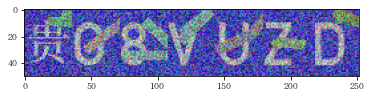

In [16]:
plt.imshow(X_test[42])
to_text(Y_predict[42])